<a href="https://colab.research.google.com/github/yogendra1109/Sales_forecasting/blob/main/Sales_forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
train_path = ('/content/drive/My Drive/Hackathon/train7.csv')
test_path = ('/content/drive/My Drive/Hackathon/test7.csv')

In [3]:
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.9 MB/s eta 0:00:00
Mounted at /content/gdrive


In [4]:
!pip install numpy pandas matplotlib.pyplot seaborn  --upgrade --quite


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --quite


In [11]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 25

In [12]:
from sklearn.metrics import mean_squared_log_error
import pandas as pd

In [13]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [15]:
train.drop('Order', inplace=True, axis=1)

In [16]:
train = train[train.Sales != 0]

In [17]:
dep_var = "Sales"

In [18]:
train.columns

Index(['ID', 'Store_id', 'Store_Type', 'Location_Type', 'Region_Code', 'Date',
       'Holiday', 'Discount', 'Sales'],
      dtype='object')

In [19]:
train = add_datepart(train, 'Date')

/usr/local/lib/python3.10/dist-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [20]:
procs = [Categorify , FillMissing]

In [21]:
cond = (train.Year<2019) | (train.Month<4)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [22]:
test = add_datepart(test, 'Date')

/usr/local/lib/python3.10/dist-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [23]:
cont = ['Elapsed']
cat =['Store_id','Holiday','Year','Month','Week','Day','Dayofweek','Dayofyear','Store_Type',
  'Location_Type','Region_Code','Discount','Is_month_end','Is_month_start','Is_quarter_end',
  'Is_quarter_start','Is_year_end','Is_year_start']

In [24]:
to = TabularPandas(train, procs, cat, cont, y_names=dep_var, splits=splits)

In [25]:
len(to.train),len(to.valid)

(166060, 22261)

In [26]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [27]:
rf1 = RandomForestRegressor(n_jobs=-1, n_estimators=40, max_features=0.5,
        min_samples_leaf=5, oob_score=True,random_state=42)

In [28]:
rf1.fit(xs, y)
rf1_train_preds = rf1.predict(xs)

In [29]:
rf1_train_msle = mean_squared_log_error(y, rf1_train_preds)
print('The MSLE loss for the training set is  {}.'.format(rf1_train_msle))

The MSLE loss for the training set is  0.025640391213622767.


In [30]:
rf1_val_preds = rf1.predict(valid_xs)

In [31]:
rf1_val_msle = mean_squared_log_error(valid_y, rf1_val_preds)
print('The MSLE loss for the validation set is  {}.'.format(rf1_val_msle))

The MSLE loss for the validation set is  0.12775811015853852.


In [32]:
def rf_feat_importance(rf1, df):
    return pd.DataFrame({'cols':df.columns, 'imp':rf1.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [33]:
fi = rf_feat_importance(rf1, xs)
fi[:]

,cols,imp
8,Store_Type,0.312872
9,Location_Type,0.182902
11,Discount,0.130789
0,Store_id,0.084702
6,Dayofweek,0.065359
7,Dayofyear,0.048018
18,Elapsed,0.042679
1,Holiday,0.036516
5,Day,0.031584
4,Week,0.026465


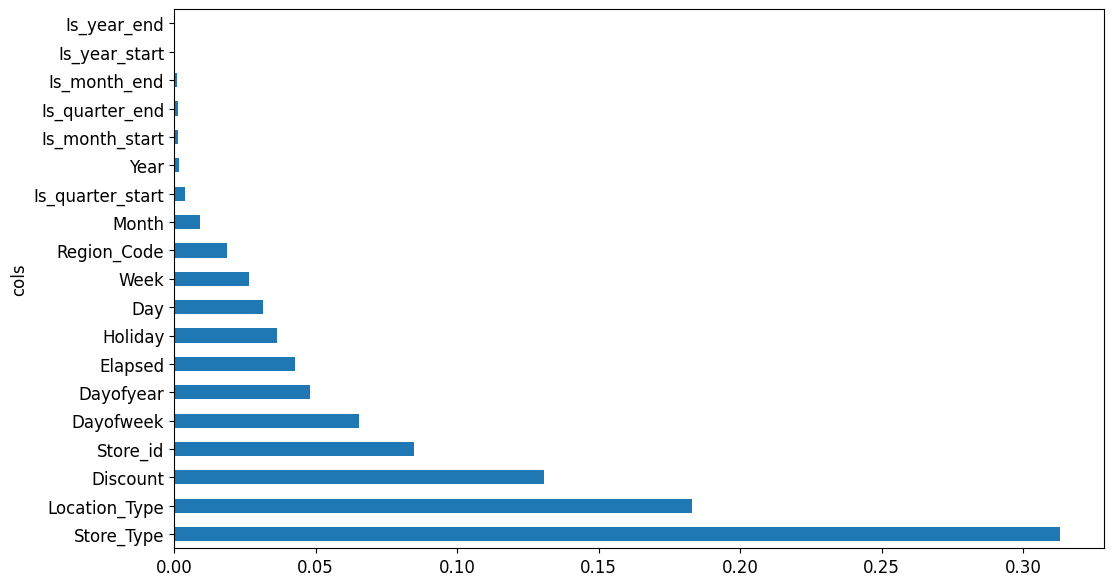

In [34]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:]);

In [35]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

12

In [36]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

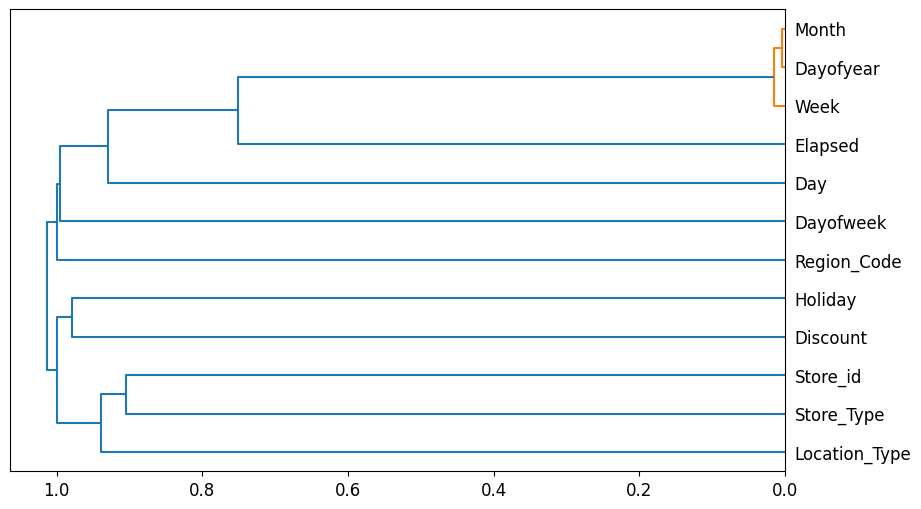

In [37]:
cluster_columns(xs_imp)

In [38]:
to_drop = ['Month']

In [39]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [40]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

In [41]:
rf1.fit(df_dom, is_valid)
rf_feat_importance(rf1, df_dom)

,cols,imp
6,Elapsed,0.899580
9,Week,0.075788
5,Dayofyear,0.023784
4,Dayofweek,0.000401
8,Day,0.000283
7,Holiday,0.000164
0,Store_Type,0.000000
1,Location_Type,0.000000
2,Discount,0.000000
3,Store_id,0.000000


In [42]:
rf1.fit(xs_final, y)
print('orig', mean_squared_log_error(valid_y, rf1.predict(valid_xs_final))*1000)

for c in ('Elapsed','Week','Dayofyear'):
    rf1.fit(xs_final.drop(c,axis=1), y)
    print(c, mean_squared_log_error(valid_y, rf1.predict(valid_xs_final.drop(c,axis = 1)))*1000)

orig 137.9308828961164
Elapsed 82.03725338623013
Week 137.1645560062415
Dayofyear 139.12236586675124


In [43]:
time_vars = ['Elapsed', 'Dayofyear']

In [44]:
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

In [45]:
def test_params(**params):
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params).fit(xs_final_time, y)
    train_msle = mean_squared_log_error(y, model.predict(xs_final_time))
    val_msle = mean_squared_log_error(valid_y, model.predict(valid_xs_time))
    return train_msle, val_msle

In [46]:
def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], []
    for value in param_values:
        params = {param_name: value}
        train_msle, val_msle = test_params(**params)
        train_errors.append(train_msle)
        val_errors.append(val_msle)
    plt.figure(figsize=(16,8))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('MSLE')
    plt.legend(['Training', 'Validation'])

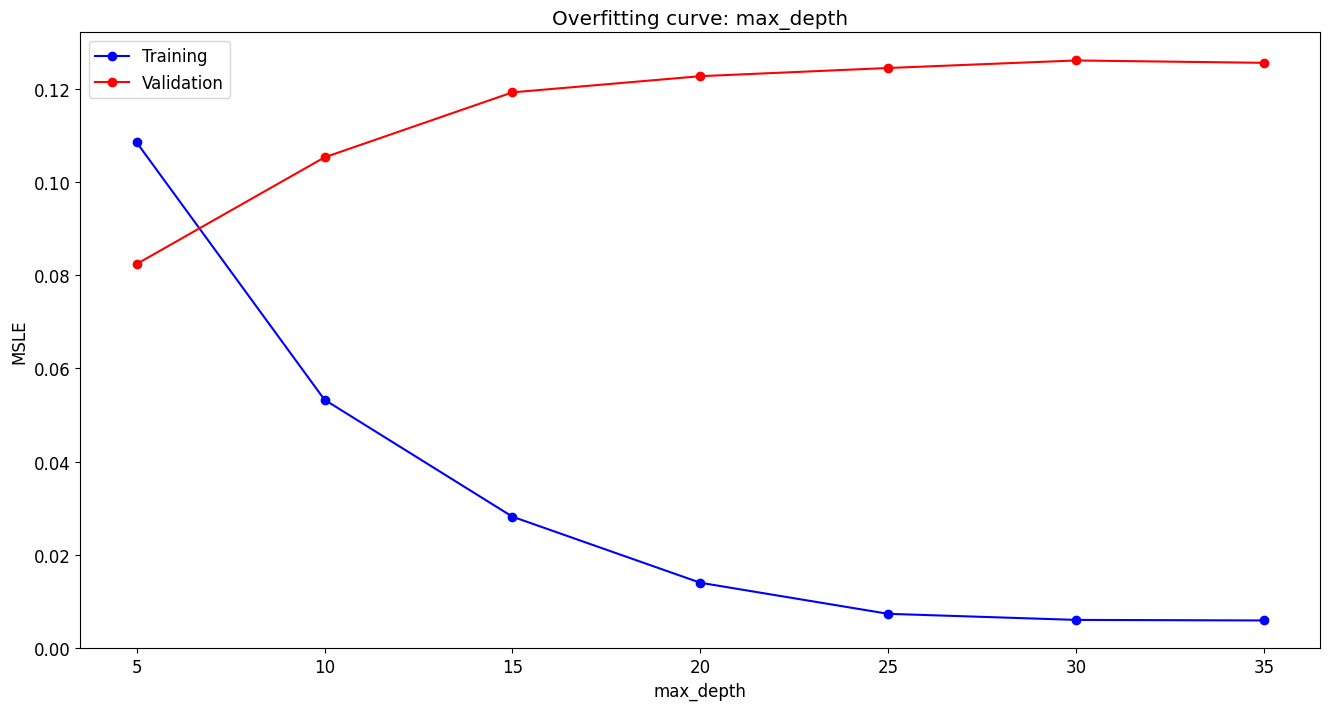

In [47]:
test_param_and_plot('max_depth', [5, 10, 15, 20, 25, 30, 35])

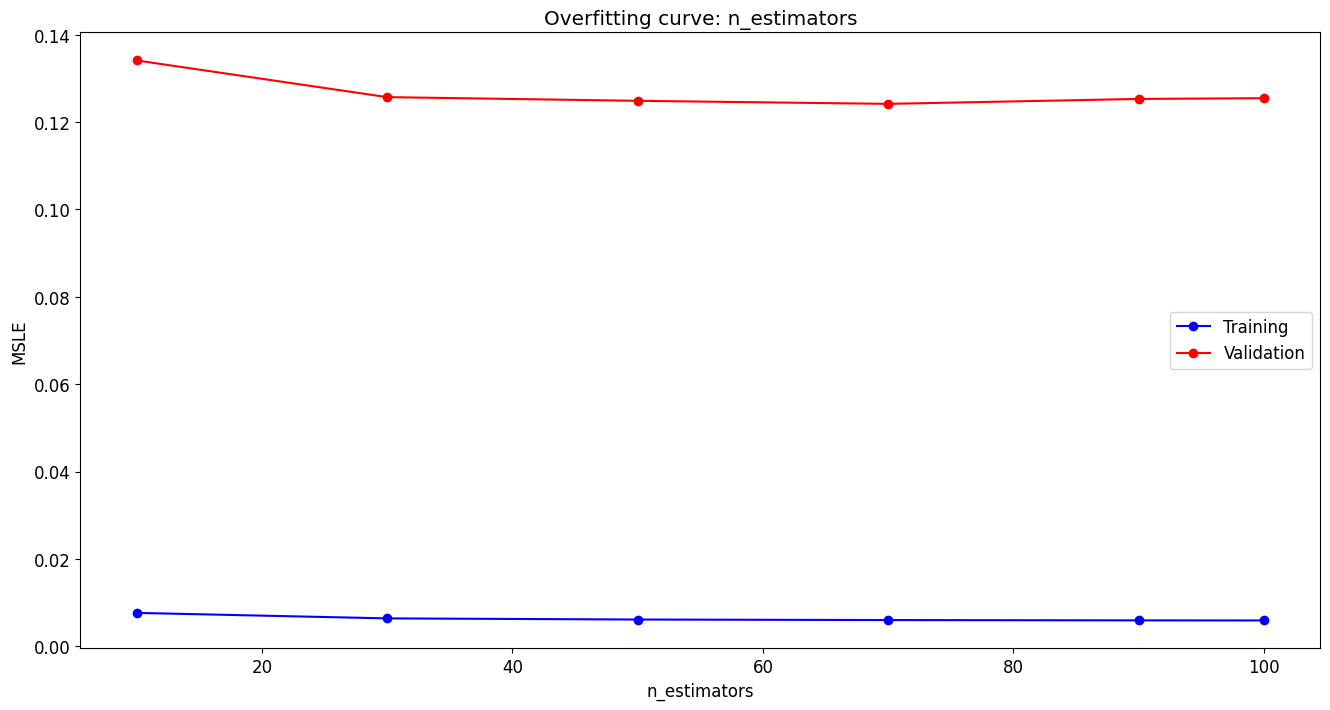

In [48]:
test_param_and_plot('n_estimators', [10, 30, 50, 70, 90, 100])

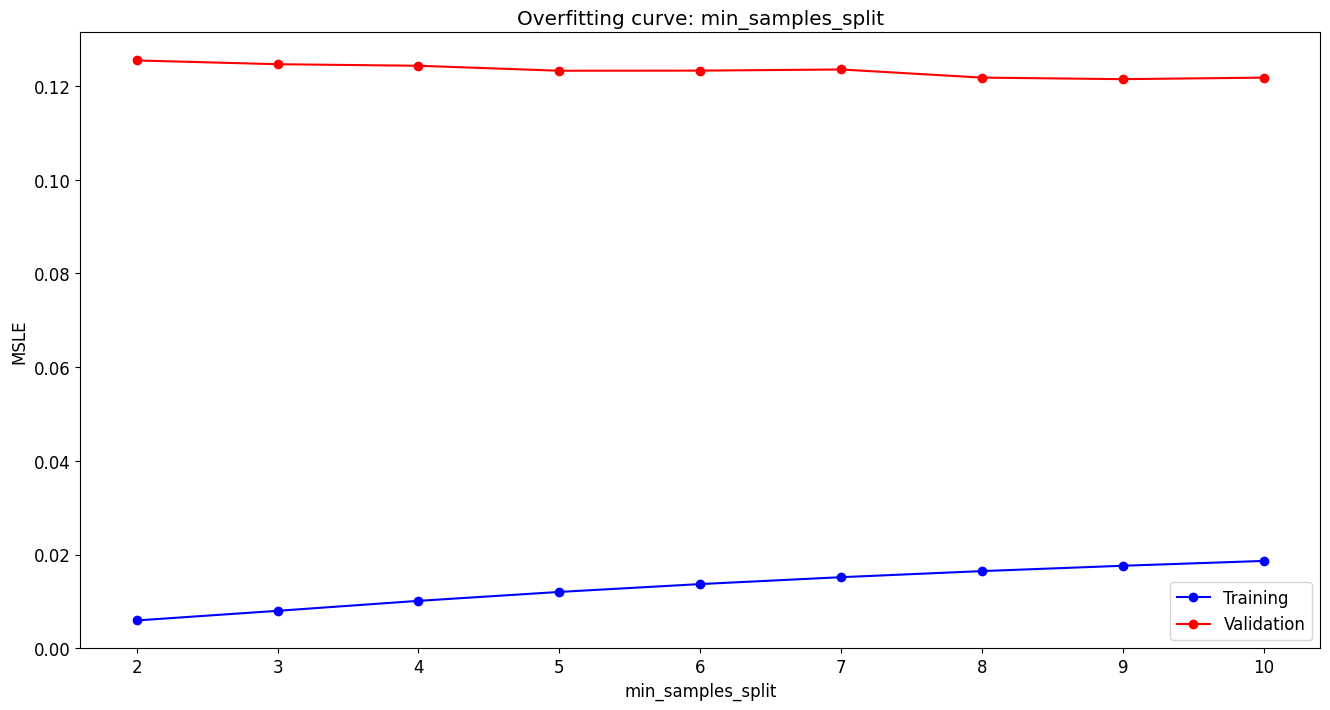

In [49]:
test_param_and_plot('min_samples_split', [2, 3, 4, 5, 6, 7, 8, 9, 10])

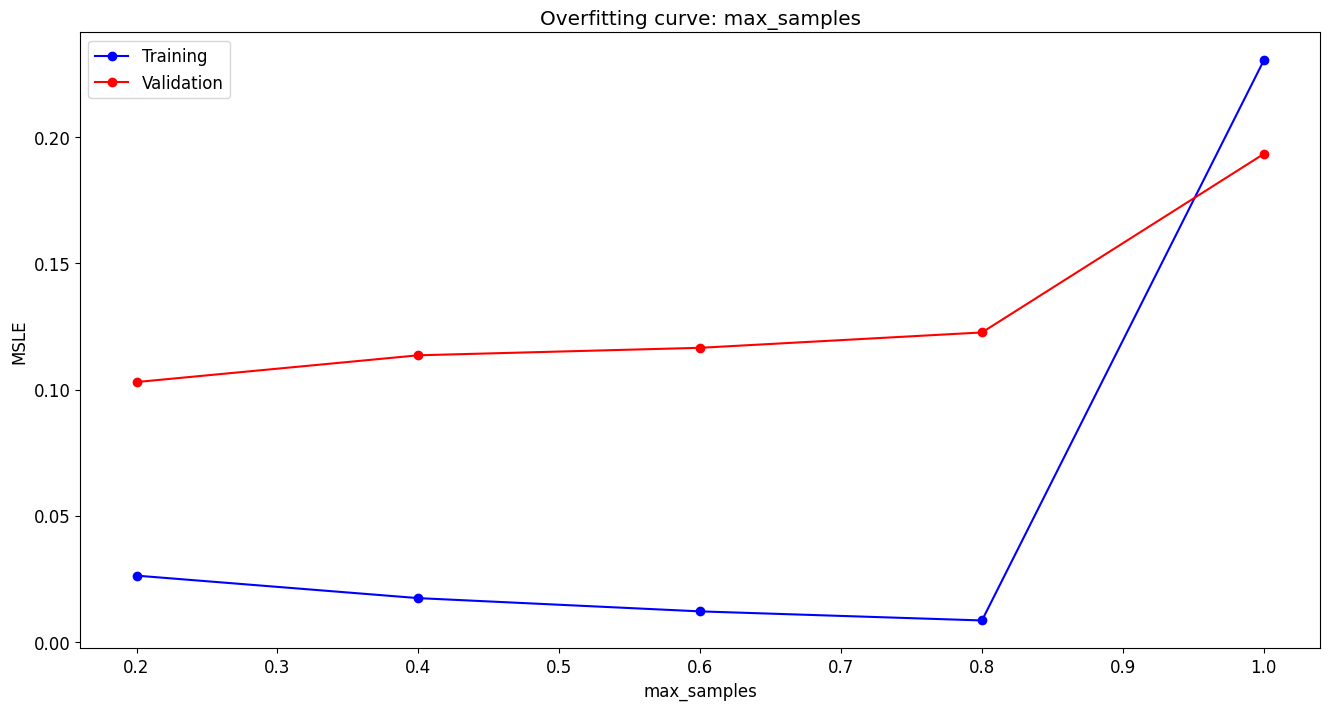

In [50]:
test_param_and_plot('max_samples', [0.2, 0.4, 0.6, 0.8, 1])

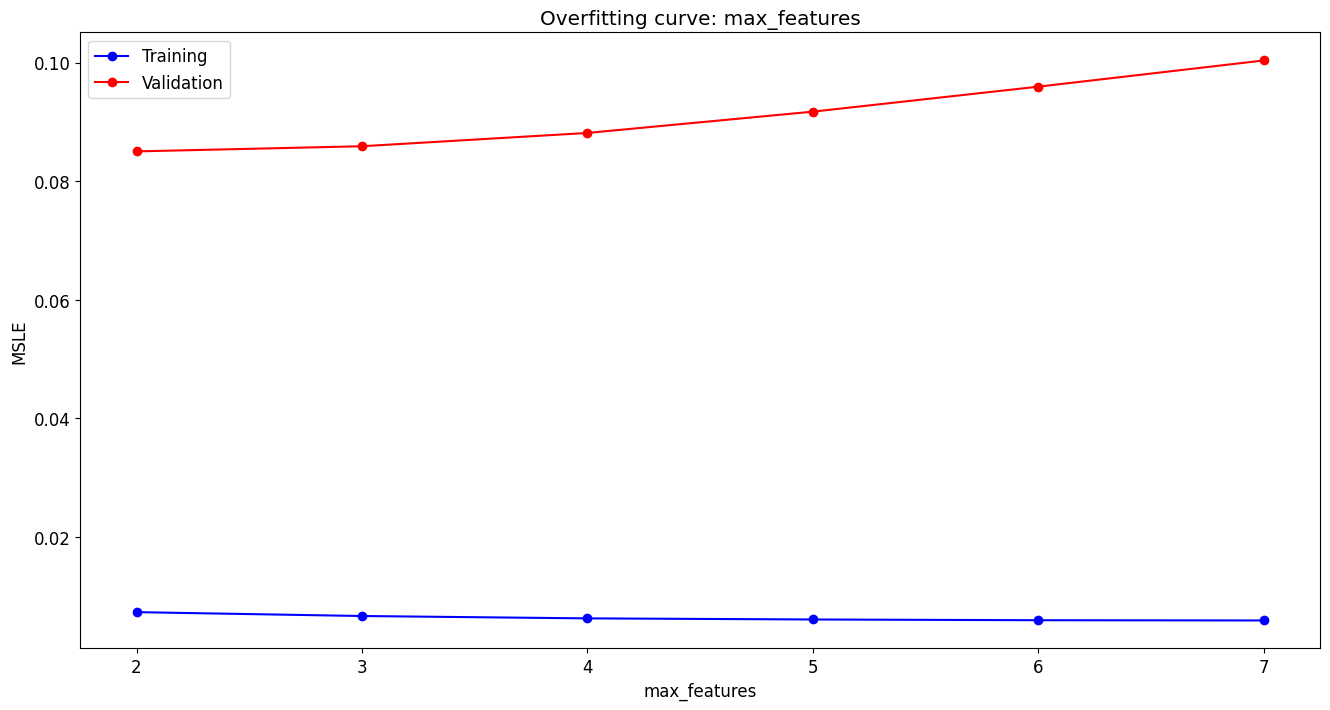

In [51]:
test_param_and_plot('max_features', [2, 3, 4, 5, 6, 7])

In [52]:
rf1 = RandomForestRegressor(n_jobs=-1, max_depth=30, n_estimators=60, min_samples_split=8,
                            min_samples_leaf=10, max_samples=0.8, max_features=6,  random_state=42)

rf1.fit(xs_final_time, y)
rf1_train_preds = rf1.predict(xs_final_time)

In [53]:
rf1_train_msle = mean_squared_log_error(y, rf1_train_preds)
print('The MSLE loss for the training set is  {}.'.format(rf1_train_msle))
rf1_val_preds = rf1.predict(valid_xs_time)
rf1_val_msle = mean_squared_log_error(valid_y, rf1_val_preds)
print('The MSLE loss for the validation set is  {}.'.format(rf1_val_msle))

The MSLE loss for the training set is  0.03435138673107341.
The MSLE loss for the validation set is  0.08857037320299085.


In [54]:
test.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Discount,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,T1188341,171,S4,L2,R3,0,No,2019,6,22,1,5,152,False,True,False,False,False,False,1.559347e+09
1,T1188342,172,S1,L1,R1,0,No,2019,6,22,1,5,152,False,True,False,False,False,False,1.559347e+09
2,T1188343,173,S4,L2,R1,0,No,2019,6,22,1,5,152,False,True,False,False,False,False,1.559347e+09
3,T1188344,174,S1,L1,R4,0,No,2019,6,22,1,5,152,False,True,False,False,False,False,1.559347e+09
4,T1188345,170,S1,L1,R2,0,No,2019,6,22,1,5,152,False,True,False,False,False,False,1.559347e+09


In [56]:
test['Sales'] = 0

In [57]:
to_test = TabularPandas(test, procs, cat, cont, y_names=dep_var)

In [58]:
test_xs_imp = to_test.xs[to_keep]

In [59]:
test_xs_final = test_xs_imp.drop(to_drop, axis=1)

In [60]:
test_xs_final.shape

(22265, 11)

In [61]:
test_xs_time = test_xs_final.drop(time_vars, axis=1)

In [62]:
test_xs_time .shape

(22265, 9)

In [63]:
df_rf_red = pd.DataFrame()

In [64]:
df_rf_red['ID'] = test['ID']
df_rf_red['Sales'] = rf1.predict(test_xs_time)

In [65]:
df_rf_red.head()

,ID,Sales
0,T1188341,77001.745765
1,T1188342,46218.784859
2,T1188343,87943.456060
3,T1188344,50301.798139
4,T1188345,48487.424505
